Alg High Level:
* calculate H between each image pair.
* wrap all into the first-image plane and save the transformation matrix.

* blend images using median (this is not trivial, see implementation details below). This can be used to remove moving objects by showing only the median panorama, or to show only moving objects, by masking pixels which are close to the median, thus cars(and their shadows) are visibile.
* We can also add a layer with an objects into the median-panorama, or into the source video, in the 2nd case, we will not create a median/mean panorama, as it will change the original movie. Instead we project each frame, by itself into the panorama, add objects to the same pixels in the panorama image, and then remap back the source image. The result is the original pixels + inserted layer, which was done always using coordinates in the panorama.


See result videos:
* output_source_insertion.mp4  - insertion of open university logo on the top white building (toward end of the movie, second 11-13)
* output_median_with_insertion.mp4  - same on the median video
* output_median_clean.mp4 - clean median video , without insertion
* output_moving.mp4 - only the moving parts

Images:
    <img src="matches.png" width="1000">
    <img src="panorama.png" width="600">>

  


learning material:
    https://www.pyimagesearch.com/2016/01/11/opencv-panorama-stitching/
    https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html#py-feature-homography
    https://docs.opencv.org/trunk/d1/d46/group__stitching.html  (Stitching pipeline:  not used here)

        

In [260]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import cv2
%matplotlib inline

def read_whole_vid(name):
    ''' read the video and return frame_list'''
    vid=None
    frame_i=-1
    frame_list =[]

    try:
       vid = cv2.VideoCapture(name)
       print ('reading',vid.isOpened(),vid.get(cv2.CAP_PROP_FPS))
       while(vid.isOpened() and frame_i<1000):
          frame_i+=1
          ret, frame = vid.read()
          if not ret: # end of vid
                break  
          frame_list.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    except NameError as e:
       print (e)
       vid.release()
    print ('done')
    print (frame_i,ret)
    return frame_list

frame_list = read_whole_vid('HW3movie.avi')
print (len(frame_list))


('reading', True, 29.97)
done
(475, False)
475


('frame', 473)
('frame', 472)
('frame', 471)
('frame', 470)
('frame', 469)
('frame', 468)
('frame', 467)
('frame', 466)
('frame', 465)
('frame', 464)
('frame', 463)
('frame', 462)
('frame', 461)
('frame', 460)
('frame', 459)
('frame', 458)
('frame', 457)
('frame', 456)
('frame', 455)
('frame', 454)
('frame', 453)
('frame', 452)
('frame', 451)
('frame', 450)
('frame', 449)
('frame', 448)
('frame', 447)
('frame', 446)
('frame', 445)
('frame', 444)
('frame', 443)
('frame', 442)
('frame', 441)
('frame', 440)
('frame', 439)
('frame', 438)
('frame', 437)
('frame', 436)
('frame', 435)
('frame', 434)
('frame', 433)
('frame', 432)
('frame', 431)
('frame', 430)
('frame', 429)
('frame', 428)
('frame', 427)
('frame', 426)
('frame', 425)
('frame', 424)
('frame', 423)
('frame', 422)
('frame', 421)
('frame', 420)
('frame', 419)
('frame', 418)
('frame', 417)
('frame', 416)
('frame', 415)
('frame', 414)
('frame', 413)
('frame', 412)
('frame', 411)
('frame', 410)
('frame', 409)
('frame', 408)
('frame', 

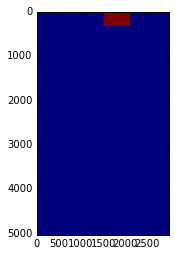

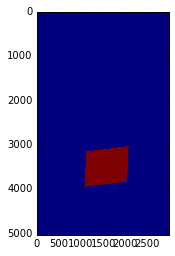

('total_frames', 474, 'jumps between frames', 1)


In [329]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

def mem_usage():
    import os
    import psutil
    process = psutil.Process(os.getpid())
    print('MEM:%d MB'% (process.memory_info().rss/(1024*1024)))



def find_H(rgb1,rgb2,affine=False,verbose=False):
    """
    Find Homography matrix between two images.  (Homography is more generic than the Affine transform needed for ariel images, allowing to use it for different scenarios)
    the algorithm is short:
    * Run SIFT on the two images and extract descriptors
    * use KDTree to find 2 KNN (closest 2 matches)  for each descriptor
    * filter out matches if both are roughly the same distance (which means we are not sure in either of them)
    * if enough matches are found, calculate cv2.findHomography and return it
    * For verbose, also show the changes
    * see tutorial in: https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html#py-feature-homography
    """
    img1 = cv2.cvtColor(rgb1,cv2.COLOR_RGB2GRAY)
    img2 = cv2.cvtColor(rgb2,cv2.COLOR_RGB2GRAY)

    MIN_MATCH_COUNT = 10

    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    LOWES_THRESHOLD=0.3 #0.7
    for m,n in matches:
        if m.distance < LOWES_THRESHOLD * n.distance:
            good.append(m)

    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        if not affine:
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0,maxIters=50)
            if verbose:
                matchesMask = mask.ravel().tolist()
                h,w = img1.shape
                pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
                dst = cv2.perspectiveTransform(pts,M)

                img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

                draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                                   singlePointColor = None,
                                   matchesMask = matchesMask, # draw only inliers
                                   flags = 2)
                img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
                plt.figure(figsize=(20,20))
                plt.imshow(img3, 'gray'),plt.show()
        else:
            A = cv2.estimateRigidTransform(src_pts, dst_pts,True) 
            M = np.identity(3) 
            M[:2,:3]=A  #we use homography in general, so just copy the relevant parameters 

    else:
        raise ValueError("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    return M


def show_p(p,title=''):
    plt.figure(figsize=(20,6))
    plt.title(title)
    plt.imshow(p)
    plt.show()

def wrap(H,rgb1,p,verbose=False):
    p= cv2.warpPerspective(rgb1,
                           H,
                          (p.shape[1],p.shape[0]),
                           flags=cv2.INTER_CUBIC,
                        )
    mask = p.sum(axis=2)>0
    return p,mask



class FrameData:
    def __init__(self,i,mask,H):
        '''
        i - frame number in the original movie
        mask
        H - homography matrix to base-frame
        '''
        self.i = i
        self.mask =mask
        self.H = H
        

# we need to choose the final panorama size , and where will the reference frame
# be inside it. One can calculate it by first calculating all homographies and then 
# choose one inside. In this movie, we hardcode it

prev_i=len(frame_list)-1  #we start from the end,as the movie progress up
rgb1 = frame_list[prev_i]

tx=rgb1.shape[1]*2.5
ty=0
H = np.array([[1,0,tx],
              [0,1,ty],
              [0,0,1]],np.float32)

# when stopping in 200 frames choose *15
#when stopping in all, choose ~30-35
def empty_panorama():
    p = np.zeros((rgb1.shape[0]*15, int(rgb1.shape[1]*5), 3),dtype=np.uint8)
    return p

p = empty_panorama()


frame_data=[]

# add first outside the loop
wrap_on_t,mask = wrap(H,rgb1,p,False) 
frame_data.append(FrameData(prev_i,mask,H))

jumps=1
#for i in range(prev_i-jumps,max(0,prev_i-10*jumps),-jumps):
for i in range(prev_i-jumps,0,-jumps):
    print ('frame',i)
    rgb1=frame_list[prev_i]
    rgb2=frame_list[i]
    current_H = find_H(rgb2, rgb1 ,affine=True,verbose=False)

    H = np.dot(H,current_H)  #(H01 @ H12)
    wrap_on_t,mask = wrap(H,rgb2,p,verbose=False) 
    frame_data.append(FrameData(i,mask,H))
    prev_i=i

plt.imshow(frame_data[0].mask)
plt.show()
plt.imshow(frame_data[-1].mask)
plt.show()

print ('total_frames',len(frame_data),'jumps between frames',jumps)

In [366]:
import time


def hacky_blend_median(frame_data):
    """
        -not-used
        Imagine 3 images, partially filled (mask shows which part are non-zero) with partial-alignment.
        A simple hack is to zig-zap 255 and 0 on all the images in non-mask locations
    """
    flip_counter=1
    for i in range(len(frame_data)):
        p , mask = frame_data[i].p,frame_data[i].mask
        p[np.logical_not(mask)]=(255*flip_counter)  # super-hack
        flip_counter = not flip_counter

    med = np.stack([frame.p for frame in frame_data],axis=0)  # size of N,H,W,3  where N is the #images
    med = np.median(med,axis=0).astype(np.uint8) #returning to H,W,3
    return med


def logical_minus(A,B):
    # logical minus = A-B = A & notB
    return np.logical_and(A,np.logical_not(B))

def get_masks(frame_data,relevant_frames,jumps,max_frames):
    first = relevant_frames[0]
    last  = relevant_frames[-1]
    all = np.stack([frame_data[i].mask for i in relevant_frames],axis=0)
    mask= (all.sum(axis=0)==len(relevant_frames))

    #remove mask of previous and forward frames
    one_before = first-jumps
    if (one_before>=0):
        mask = logical_minus(mask,frame_data[one_before].mask)
    one_after = last+jumps
    if (one_after<max_frames):
        mask = logical_minus(mask,frame_data[one_after].mask)
    return mask


def blend_median(frame_data):
    '''
    create all_masks intersections. can take above minute for jumps=5, as it's not fully optimized.
    better-optimization can be:
       intersecting-masks : instead of using large masks, calculate wrapped-polynoms intersections
       finding intersecting wrapped pixel: instead of wrapping all the image(on the panorama) calculate only relevant pixels (+ pixel on each side for interpolution)
       median can be done on that area , with bounding-box around it( can be calculated with contour finding on edges of mask)
       
    Another hackier option may be to use the hacky-approach, but do it on large range of images, with overlap (1-10 then 5-15)
    
    '''
    p = empty_panorama()
    max_frames = len(frame_data)
    jumps=5
    for first in range(0,max_frames,jumps):
        print ('processing masks starting with frame',first)
        mask_time, wrap_time,med_time=0,0,0
        for last in range(first,max_frames,jumps):
            # create a positive mask as intersection of all frames between first and last
            # MINUS frames before or after this range
            relevant_frames = range(first,last+1,jumps)
            print (relevant_frames)
            start_time = time.time()
            mask= get_masks(frame_data,relevant_frames,jumps,max_frames)
            if mask.sum()==0:
                print ('breaking as mask is empty',first,last)
                break
            mask_time += (time.time()-start_time)
        
            start_time = time.time()
            relevant_rgbs=[]
            for i in relevant_frames:
                rgb = frame_list[frame_data[i].i]
                wrapped_rgb = cv2.warpPerspective(rgb,
                                    frame_data[i].H,
                                    (p.shape[1],p.shape[0]) )
                relevant_rgbs.append(wrapped_rgb)
            wrap_time += (time.time()-start_time)
            
            start_time = time.time()
            med = np.stack(relevant_rgbs,axis=0)  # size of N,H,W,3  where N is the #images
            med = np.median(med,axis=0).astype(np.uint8) #returning to H,W,3
            med_time += (time.time()-start_time)
            
            p[mask>0] = med[mask>0]
        print ('frame %d: times mask %d wrap %d med %d' % (first,mask_time,wrap_time,med_time))

    return p      
            
med=blend_median(frame_data)          
plt.figure(figsize=(40,40))
plt.imshow(med[:,:,:])
plt.show()
med_backup = np.copy(med)
print ('done') 

('processing masks starting with frame', 0)
[0]
[0, 5]
[0, 5, 10]
[0, 5, 10, 15]
[0, 5, 10, 15, 20]
[0, 5, 10, 15, 20, 25]
[0, 5, 10, 15, 20, 25, 30]
[0, 5, 10, 15, 20, 25, 30, 35]
[0, 5, 10, 15, 20, 25, 30, 35, 40]
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]
('breaking as mask is empty', 0, 85)
frame 0: times mask 6 wrap 17 med 66
('processing masks starting with frame', 5)
[5]
[5, 10]
[5, 10, 15]
[5, 10, 15, 20]
[5, 10, 15, 20, 25]
[5, 10, 15, 20, 25, 30]
[5, 10, 15, 20, 25, 30, 35]
[5, 10, 15, 20, 25, 30, 35, 40]
[5, 10, 15, 20, 25, 30, 35,

KeyboardInterrupt: 

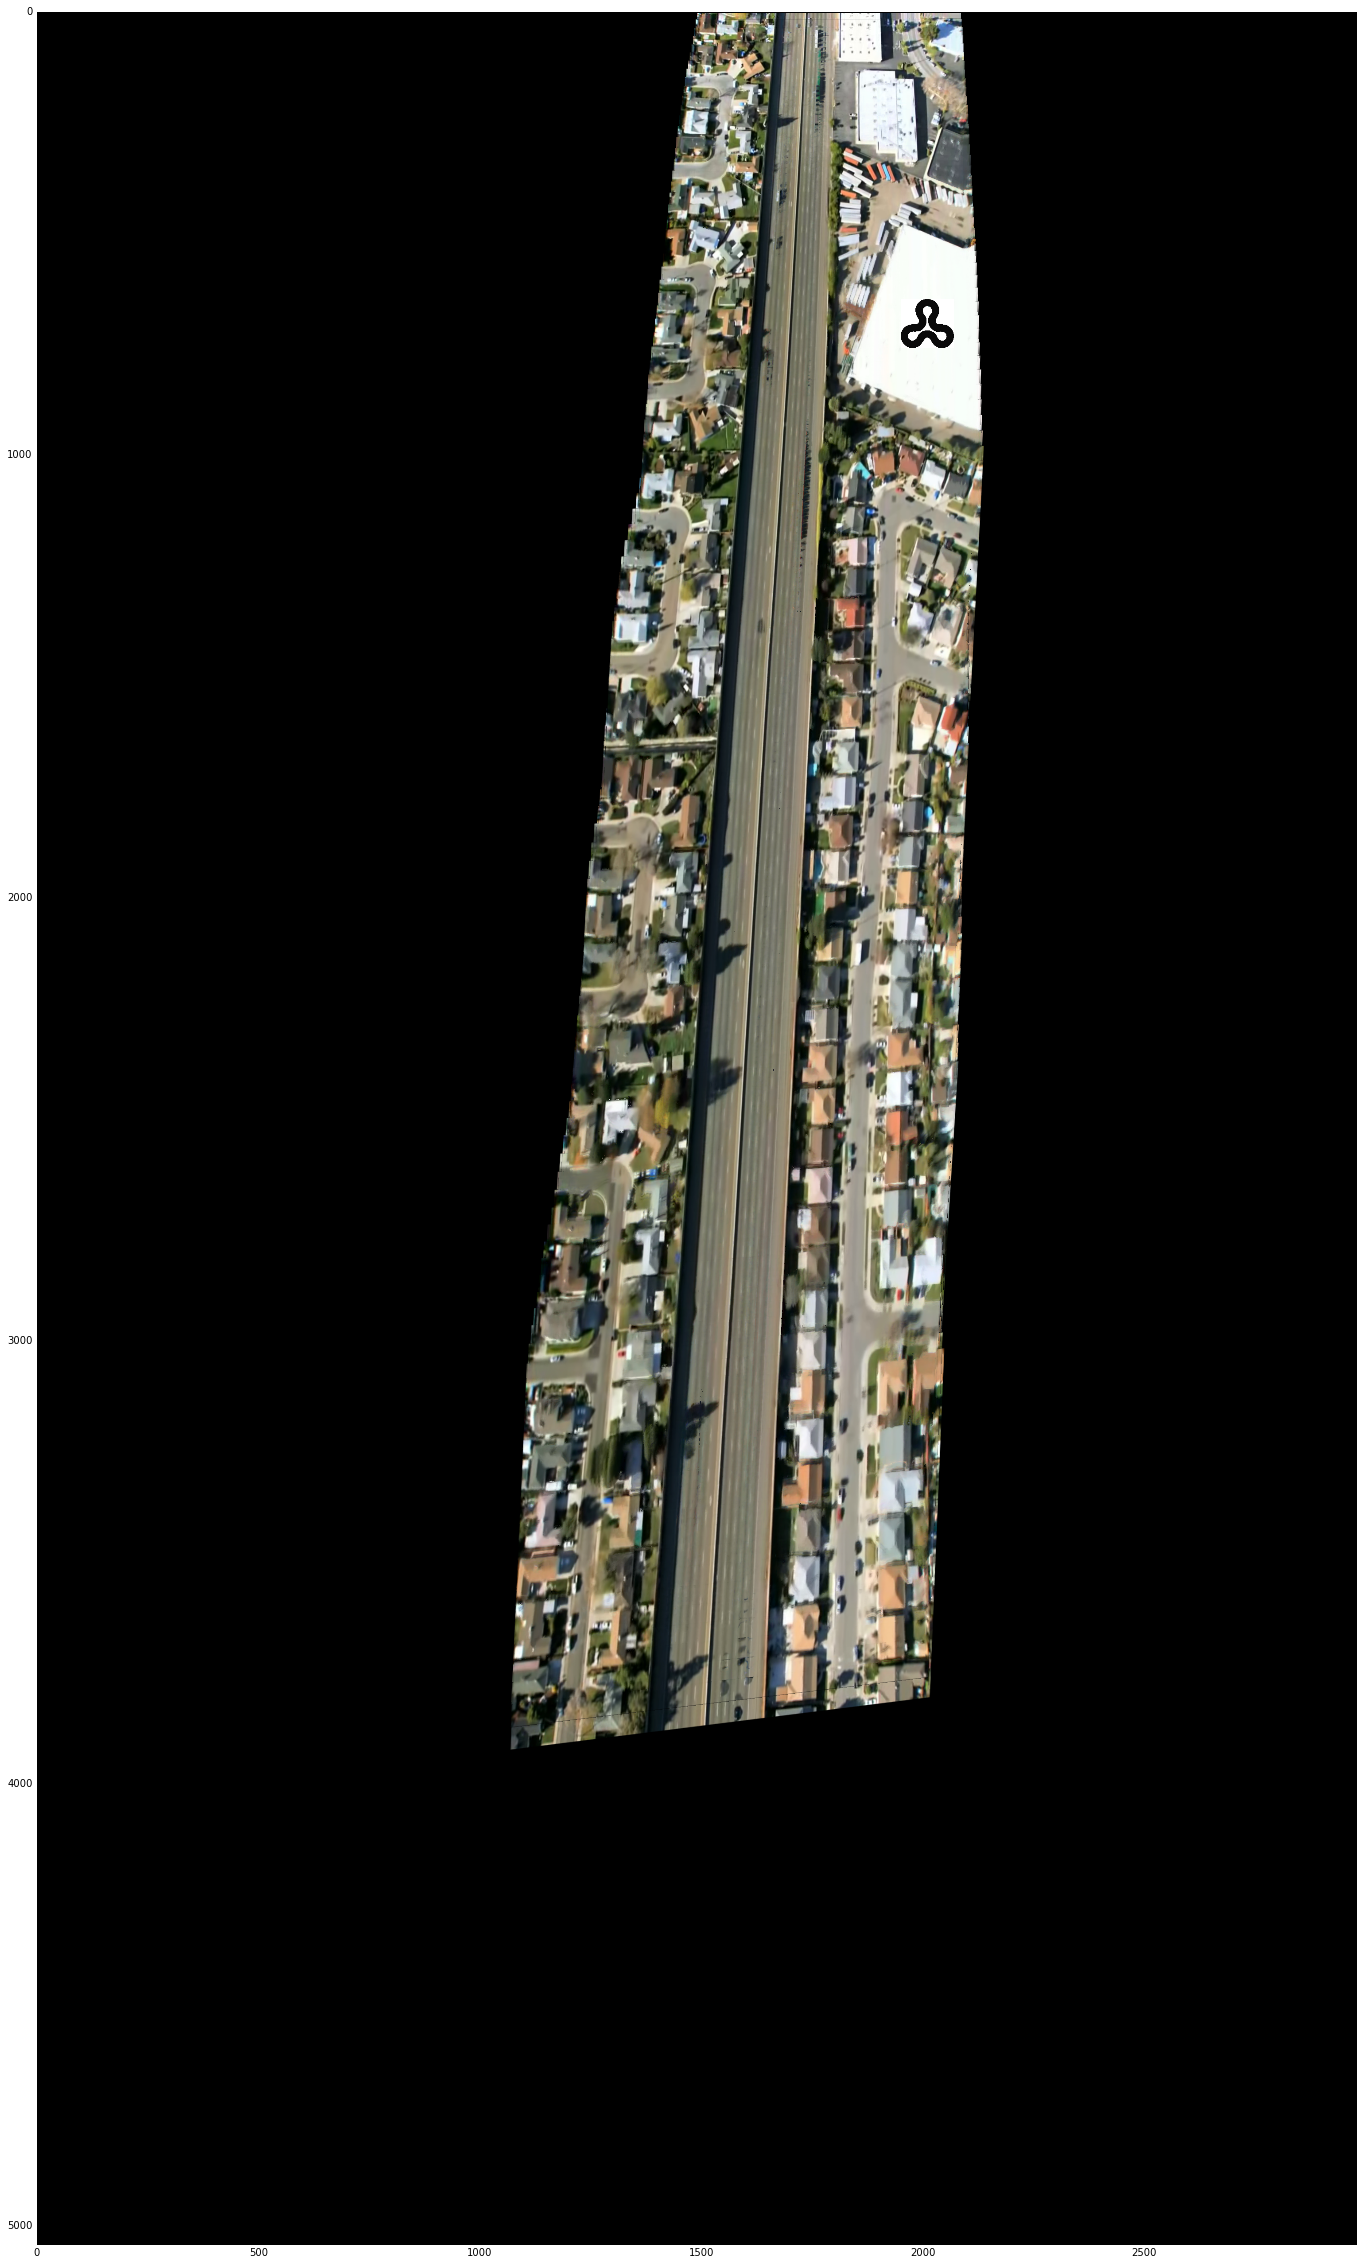

In [363]:
#insert university logo on top of one of building
med= np.copy(med_backup)

insertion = cv2.imread('insertions.png')
insertion=255-insertion
insertion[insertion<254]=10

h,w,_=insertion.shape
insertion=cv2.resize(insertion,(w/10,h/10),interpolation=cv2.INTER_LANCZOS4)
h,w,_=insertion.shape
med[650:650+h,1950:1950+w]= insertion 

# see it in the top-right on the large white building
plt.figure(figsize=(40,40))
plt.imshow(med[:,:,:])
plt.show()


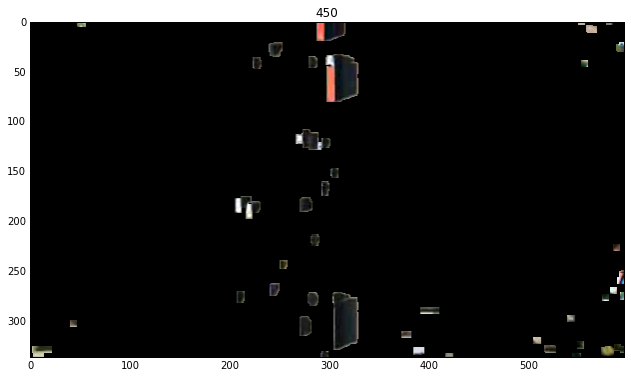

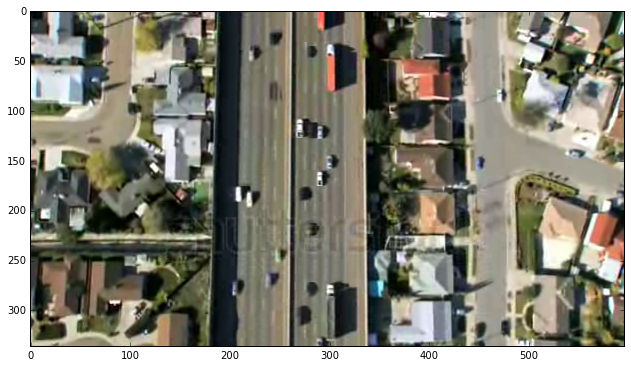

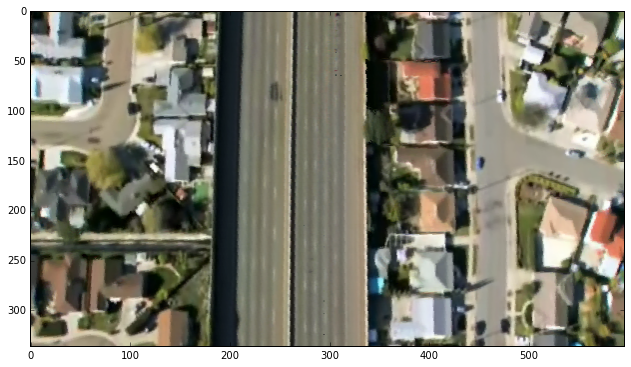

In [423]:
# only show moving objects

def diff_from_median(source,median,threshold=50):
    # do diff between the two images, move to int32 to avoid overflow
    diffs = np.abs(source.astype(np.int32) - median.astype(np.int32))
    # sum the diffs in RGB channels, if it's above threshold, this is a 'moving-object'
    diffs= diffs.max(axis=2)  #sum 
    mask = (diffs>= threshold).astype(np.uint8)
    
    # remove thin lines using erode-dilate kernes
    mask = cv2.erode(mask ,np.ones((5,5),np.uint8))
    mask = cv2.dilate(mask,np.ones((7,7),np.uint8))
    return cv2.bitwise_and(source,source,mask=mask)


def test(frame_i):
    frame = frame_data[frame_i]
    
    source=frame_list[frame.i]
    h,w, _ =  source.shape
    median= cv2.warpPerspective(med,
                                 frame.H,
                                  (w,h),
                                  flags=cv2.WARP_INVERSE_MAP
                                )
    
   
    #for threshold in range(0,50,10): #for max smaller numbers
    diffs=diff_from_median(source,median)#,threshold)
    show_p(diffs,threshold)
    
    show_p(source)
    show_p(median)

test(230)
    

    
    

In [384]:
def save_video(panorama,frame_data,file_name,moving_only=False):
    h,w, _ =  frame_list[0].shape
    out = cv2.VideoWriter(file_name,cv2.VideoWriter_fourcc('M','J','P','G'), 30, (w,h))

    try:
        for frame in (frame_data[::-1]):
            
            p = cv2.warpPerspective(panorama,
                               frame.H,
                              (w,h),
                              flags=cv2.WARP_INVERSE_MAP
            )
            if moving_only:
               p = diff_from_median(frame_list[frame.i],p,threshold=50)  
            out.write(cv2.cvtColor(p,cv2.COLOR_RGB2BGR))
    except:
        print ("Unexpected error:", sys.exc_info())
    out.release()
    print ('done')

print ('note: it may open an opencv choose-coded menu on windows, choose Microsoft if you use Windows')    
save_video(med_backup,frame_data,'output_median_clean.avi')
save_video(med,frame_data,'output_median_with_insertion.avi')
save_video(med_backup,frame_data,'output_moving.avi',moving_only=True)

note: it may open an opencv choose-coded menu on windows, choose Microsoft if you use Windows
done
done
done


In [437]:
def insert_layer(p):
    insertion = cv2.imread('insertions.png')
    insertion=255-insertion
    insertion[insertion<254]=10
    #print (p.shape,insertion.shape)
    h,w,_=insertion.shape
    insertion=cv2.resize(insertion,(w/10,h/10),interpolation=cv2.INTER_LANCZOS4)
    h,w,_=insertion.shape
    p[650:650+h,1950:1950+w]= insertion 
    


def save_video_insertion(frame_data,file_name):
    h,w, _ =  frame_list[0].shape
    out = cv2.VideoWriter(file_name,cv2.VideoWriter_fourcc('M','J','P','G'), 30, (w,h))
    try:
        for frame in (frame_data[::-1]):
            print (frame.i)
            p = empty_panorama()
            
            p,_ = wrap(frame.H,frame_list[frame.i],p)
            insert_layer(p)

            p = cv2.warpPerspective(p,
                               frame.H,
                              (w,h),
                              flags=cv2.WARP_INVERSE_MAP
            )
            out.write(cv2.cvtColor(p,cv2.COLOR_RGB2BGR))
    except:
        print ("Unexpected error:", sys.exc_info())
    out.release()
    print ('done')

save_video_insertion(frame_data,'video_insertion.avi')

done


In [ ]:
def rewrite_original():
    ''' rewrites the original movie, after reading it, without any image processing. just to check the codecs'''
    out = cv2.VideoWriter('reinput.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 30, (w,h))
    print ('it will open an opencv choose-coded menu on windows, choose Microsoft if you use Windows')
    try:
        for i,frame in enumerate(frame_list):
            if i%20==0:
                print (i) #frame.H
            out.write(cv2.cvtColor(frame,cv2.COLOR_RGB2BGR))
    except:
        print ("Unexpected error:", sys.exc_info())
    out.release()
    print ('done')
#rewrite_original()